In [2]:
import os, sys, time, glob, json, math, warnings, csv
import tifffile as tif
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.spatial.distance as spd
import scipy.cluster as scc
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import zoom
from scipy import ndimage

from itertools import chain

In [3]:
# have you run this before? if so, try make_grid = 0 to skip long waits for computing
#else use make_grid = 1
make_grid = 0

In [4]:
# location of your repo clone
sys.path.append("../../..")

In [5]:
# base path
src = "/home/emilyjanedennis/Desktop/"

In [6]:
def get_dists(val,list_of_vals):
    dists = []
    for comp_val in list_of_vals:
        dists.append(math.dist(val,comp_val))
    return dists

In [7]:
def make_heatmap(matrix):
    fig, ax = plt.subplots(figsize=(100,30))
    heatmap = ax.pcolor(matrix, cmap=plt.cm.bone_r)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
    ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

    ax.set_xlim([0, matrix.shape[1]])
    ax.set_ylim([0, matrix.shape[0]])          

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    return fig, ax

In [8]:
def get_dist(original_coords,new_coords):
    tst=np.array(new_coords)
    squared_dist = np.sum((original_coords-tst)**2, axis=0)
    dist = np.sqrt(squared_dist)
    return dist

In [9]:
def get_cosine_sim(vect,matrix_for_comparison):
    #cosine similarity
    list_of_cosines=[]
    for val in matrix_for_comparison:
        list_of_cosines.append(spd.cosine(vect,val))
    cosine_sorted_indices = np.argsort(list_of_cosines)
    cosine_sorted = list_of_cosines.copy()
    cosine_sorted.sort()
    return cosine_sorted

In [10]:
def get_similar_vals_and_save(n,matrix):
    vect=matrix[n]
    matrix_for_comparison=np.array(matrix)

    # find most similar vector(s)
    #cosine similarity
    list_of_cosines=[]
    for val in matrix_for_comparison:
        list_of_cosines.append(spd.cosine(vect,val))
    cosine_sorted_indices = np.argsort(list_of_cosines)
    cosine_sorted = list_of_cosines.copy()
    cosine_sorted.sort()
    num_cosines_to_plot = np.sum([np.array(cosine_sorted) < 0.15])

    # plot
    if num_cosines_to_plot < 4:
        num_cosines_to_plot=4
    cosine_to_plot = matrix_for_comparison[cosine_sorted_indices[0:int(num_cosines_to_plot)]]


    plt.figure(figsize=(10,7))
    for i in np.arange(0,num_cosines_to_plot):
        plt.plot(cosine_to_plot[i],'k',alpha=0.1)
        plt.plot(vect,'k',alpha=0.1)
    plt.title('{} most similar expression patterns \n cosines {}'.format(num_cosines_to_plot,cosine_sorted[0:int(num_cosines_to_plot)]))
    plt.savefig('../../../../../most_similar_to_{}.eps'.format(row_labels[cosine_sorted_indices[0]]))


In [11]:
def get_segmented_and_bool_vols_in_atlvol(cells_floored,bool_cell_vol,segmented_cell_vol,atlvol):
    for i in np.arange(0,np.shape(cells_floored)[0]):
        z,y,x=cells_floored[i]
        try:
            bool_cell_vol[z,y,x]=1
            if atlvol[z,y,x]>0:
                segmented_cell_vol[z,y,x]=atlvol[z,y,x]
        except:
            print("{} failed".format(i))
    return bool_cell_vol, segmented_cell_vol

In [12]:
def get_closest_vals(vect,matrix_for_comparison):

    # find most similar vector(s)
    #cosine similarity
    list_of_cosines=[]
    for val in matrix_for_comparison:
        list_of_cosines.append(spd.cosine(vect,val))
    cosine_sorted_indices = np.argsort(list_of_cosines)
    cosine_sorted = list_of_cosines.copy()
    cosine_sorted.sort()
    num_cosines_to_plot = int(np.sum([np.array(cosine_sorted) < 0.15]))

    # plot
    if num_cosines_to_plot < 4:
        num_cosines_to_plot=4
    cosine_list = cosine_sorted_indices[0:num_cosines_to_plot]
    print(cosine_sorted[0:num_cosines_to_plot])
    cosine_to_plot = matrix_for_comparison[cosine_sorted_indices[0:int(num_cosines_to_plot)]]
    return cosine_list, cosine_to_plot
    

In [13]:
def get_cosine_matrix(input_matrix):
    all_cosines=[]
    list_of_cosines=[]
    for i in np.arange(0,len(input_matrix)):
        list_of_cosines=[]
        val_row=input_matrix[i]
        for row in input_matrix:
            list_of_cosines.append(spd.cosine(row,val_row))
        all_cosines.append(list_of_cosines)
    return all_cosines

In [27]:
def remove_unwanted_columns(input_df):
    list_to_rm=[col for col in input_df.columns if 'Unnamed' in col]
    output_df=input_df.drop(columns=list_to_rm)
    return output_df

In [64]:
# inputs: vect, matrix for comparison
# outputs: cosine_list, cosine_indices, similar_vectors
def get_similar_vectors(vect,matrix_for_comparison,min_num_cosines):
    list_of_cosines=[]
    for val in matrix_for_comparison:
        list_of_cosines.append(spd.cosine(vect,val))
    cosine_sorted_indices = np.argsort(list_of_cosines)
    cosine_sorted = list_of_cosines.copy()
    cosine_sorted.sort()
    num_cosines_to_plot = int(np.sum([np.array(cosine_sorted) < 0.5]))
    if num_cosines_to_plot < int(min_num_cosines):
        num_cosines_to_plot=int(min_num_cosines)
    cosine_list = cosine_sorted[0:num_cosines_to_plot]
    cosine_indices = cosine_sorted_indices[0:num_cosines_to_plot]
    similar_vectors=[matrix_for_comparison[val] for val in cosine_sorted_indices[0:int(num_cosines_to_plot)]]
    return cosine_list, cosine_indices, similar_vectors

In [14]:
fld = '/home/emilyjanedennis/Desktop/ratmouse/'

In [15]:
sigma_lab = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/SIGMA_in_PRA.csv')

In [14]:
matlas_in_mPRA = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/matlas_grid_30_in_mPRA.tif')
df_30 = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/grid_with_vx.csv')

In [16]:
# get rat in matlas
# take bool cell volumes, segment, make vector
fld_of_bool = '/home/emilyjanedennis/Desktop/ratmouse'
vect_out = '/home/emilyjanedennis/Desktop/ratmouse_output'
mouse_expids_in_matlas = pd.read_csv('/home/emilyjanedennis/Desktop/2021_raritan/df_30.csv')
mouse_grid_vals = list(mouse_expids_in_matlas.grid_id)
rat_in_matlas= pd.read_csv('/home/emilyjanedennis/Desktop/df_30_rat_12062021.csv')

In [28]:
df_30_rat=remove_unwanted_columns(rat_in_matlas)

In [59]:
col_nms=[]
df_30_rat_norm = pd.DataFrame(df_30_rat.grid_id)
for col_nm in df_30_rat.columns:
    print(col_nm)
    if col_nm not in ['grid_id','voxels','M122','m128']:
        df_30_rat_norm.insert(1,col_nm,np.divide(df_30_rat[col_nm],np.max(df_30_rat[col_nm])))
        col_nms.append(col_nm)
    else:
        print('skipping {}'.format(col_nm))
    df_30_rat_norm

grid_id
skipping grid_id
M122
skipping M122
j317
z267
z265
z266
e153
e144
z268
j319
m128
skipping m128
e142
j316
voxels
skipping voxels


In [30]:
# make/get mouse data in matlas

In [31]:
mouse_expids_in_matlas[mouse_expids_in_matlas.index==0]=0 #ignore vx outside regions

In [34]:
mouse_expids_in_matlas=remove_unwanted_columns(mouse_expids_in_matlas).drop(columns=['e142','e144','grid_id','voxels'])

In [36]:
mouse_matlas_expids = mouse_expids_in_matlas.columns
mouse_matlas_expids

Index(['272824561', '113400134', '117317884', '180073473', '127710392',
       '307297141', '180917660', '174360333', '100140949', '156978574',
       ...
       '126523066', '304564721', '125361005', '272782668', '159648854',
       '121509711', '180981417', '158314987', '584903636', '304762965'],
      dtype='object', length=419)

In [55]:
df_30_mouse_matrix=mouse_expids_in_matlas.as_matrix().transpose()

mouse_matrix_in_matlas=[]
for row in df_30_mouse_matrix.copy():
    mouse_matrix_in_matlas.append(np.divide(row,np.max(row)))
mouse_norm_matrix = np.array(mouse_matrix_in_matlas)
np.save('../../../../mouse_matrix_in_matlas.npy',mouse_norm_matrix)
np.shape(mouse_norm_matrix)

/tmp/ipykernel_238720/206674776.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  df_30_mouse_matrix=mouse_expids_in_matlas.as_matrix().transpose()


(419, 2649)

In [56]:
rat_norm_matrix=df_30_rat_norm.drop(columns=['grid_id']).as_matrix().transpose()
rat_norm_matrix = np.array(rat_norm_matrix)
np.save('../../../../rat_matrix_in_matlas.npy',rat_norm_matrix)
np.shape(rat_norm_matrix)

/tmp/ipykernel_238720/95925373.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  rat_norm_matrix=df_30_rat_norm.drop(columns=['grid_id']).as_matrix().transpose()


(10, 2649)

RangeIndex(start=0, stop=2649, step=1)

In [83]:
vect_num=0
print('rat is {}'.format(col_nms[vect_num]))
[rat_cosine_list, rat_cosine_indices, rat_cosines_to_plot] = get_similar_vectors(rat_matrix_in_matlas[vect_num],rat_matrix_in_matlas,2)
print('closest rat is {}'.format(col_nms[rat_cosine_indices[1]]))
second_vect=rat_cosine_indices[1]
[cosine_list, cosine_indices, cosines_to_plot]= get_similar_vectors(rat_matrix_in_matlas[vect_num],mouse_matrix_in_matlas,4)
closest_mouse_grids=[mouse_grid_vals[val] for val in cosine_indices]
print('closest mouse grids to {} are {}'.format(col_nms[vect_num],closest_mouse_grids))
[second_cosine_list, second_cosine_indices, second_cosine_to_plot] = get_similar_vectors(rat_matrix_in_matlas[second_vect],mouse_matrix_in_matlas,4)
closest_mouse_grids_second_vect = [mouse_grid_vals[val] for val in cosine_indices]
print('closest mouse grids to {} are {}'.format(col_nms[second_vect],closest_mouse_grids_second_vect))


rat is j317
closest rat is z265
closest mouse grids to j317 are [985, 952, 1447, 477]
closest mouse grids to z265 are [985, 952, 1447, 477]


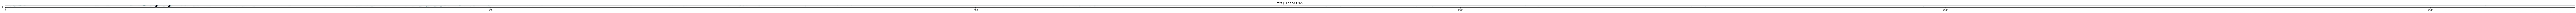

In [61]:
plt.figure(figsize=(200,20))
plt.imshow(rat_cosines_to_plot,cmap='bone_r')
plt.title('rats {} and {}'.format(col_nms[vect_num],col_nms[second_vect]))
plt.save('../../../../')

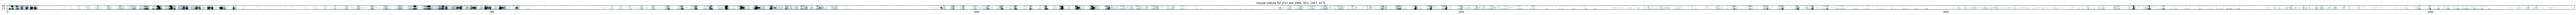

In [84]:
plt.figure(figsize=(200,20))
plt.imshow(cosine_to_plot,cmap='bone_r')
plt.title('mouse indices for {} are: {}'.format(col_nms[vect_num],closest_mouse_grids)) 
plt.show()

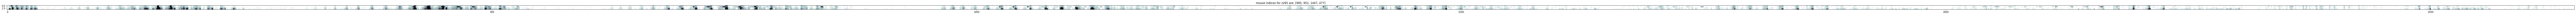

In [85]:
plt.figure(figsize=(200,20))
plt.imshow(second_cosine_to_plot,cmap='bone_r')
plt.title('mouse indices for {} are: {}'.format(col_nms[second_vect],closest_mouse_grids_second_vect)) # get list of grid vals, use instead
plt.show()

In [89]:
# summary data
# rat - closest rat grid - cosine similarity - closest mouse grids - cosine similarities
for rat_num in np.arange(0,len(col_nms)):
    print('rat is {}'.format(col_nms[rat_num]))
    [rat_cosine_list, rat_cosine_indices, rat_cosines_to_plot] = get_similar_vectors(rat_matrix_in_matlas[rat_num],rat_matrix_in_matlas,2)
    print('closest rat is {}'.format(col_nms[rat_cosine_indices[1]]))
    second_vect=rat_cosine_indices[1]
    [cosine_list, cosine_indices, cosines_to_plot]= get_similar_vectors(rat_matrix_in_matlas[rat_num],mouse_matrix_in_matlas,4)
    closest_mouse_grids=[mouse_grid_vals[val] for val in cosine_indices]
    print('closest mouse grids to {} are {}'.format(col_nms[rat_num],closest_mouse_grids))
    [second_cosine_list, second_cosine_indices, second_cosine_to_plot] = get_similar_vectors(rat_matrix_in_matlas[second_vect],mouse_matrix_in_matlas,4)
    closest_mouse_grids_second_vect = [mouse_grid_vals[val] for val in second_cosine_indices]
    print('closest mouse grids to {} are {}'.format(col_nms[second_vect],closest_mouse_grids_second_vect))


rat is j317
closest rat is z265
closest mouse grids to j317 are [985, 952, 1447, 477]
closest mouse grids to z265 are [985, 1003, 952, 477]
rat is z267
closest rat is j316
closest mouse grids to z267 are [985, 952, 961, 1003]
closest mouse grids to j316 are [985, 952, 1003, 986]
rat is z265
closest rat is j317
closest mouse grids to z265 are [985, 1003, 952, 477]
closest mouse grids to j317 are [985, 952, 1447, 477]
rat is z266
closest rat is z268
closest mouse grids to z266 are [952, 985, 477, 1505]
closest mouse grids to z268 are [371, 1112, 1144, 952]
rat is e153
closest rat is e144
closest mouse grids to e153 are [961, 1145, 1546, 875]
closest mouse grids to e144 are [952, 985, 961, 986]
rat is e144
closest rat is e153
closest mouse grids to e144 are [952, 985, 961, 986]
closest mouse grids to e153 are [961, 1145, 1546, 875]
rat is z268
closest rat is z266
closest mouse grids to z268 are [371, 1112, 1144, 952]
closest mouse grids to z266 are [952, 985, 477, 1505]
rat is j319
closes

In [102]:
matlas_grid = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/matlas_30_grid_goodonly.tif')

In [105]:
test=np.zeros(np.shape(matlas_grid))
test[matlas_grid>0]=1
test[matlas_grid==985]=100
test[matlas_grid==952]=50
test[matlas_grid==961]=25
test[matlas_grid==1003]=13
tif.imsave('/home/emilyjanedennis/Desktop/test.tif',test)

In [100]:
# get grids of inj sites or just inj sites as dots
# get top mouse grids and plot inj sites or rat grids on them, e.g. for grid 985 show j316, j319, z265, j317
# IN MATLAS SPACE

In [ ]:
# example
# j319 has centroid at 41,508,364 in mPRA